In [1]:
import os
import pandas as pd
import numpy as np

import zipfile
from urllib import request

def download_ml100k():
    # download
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    savename = "ml-100k.zip"
    request.urlretrieve(url, savename)
    print('Complete!')
    # unzip
    file_name = os.path.join('./', savename)
    file_zip = zipfile.ZipFile(file_name)
    file_zip.extractall('./')
    file_zip.close()

def read_data_ml100k():
    if not os.path.isfile(os.path.join('./ml-100k/', 'u.data')):
        print('Download ...')
        download_ml100k()
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join('./ml-100k/', 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [2]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [3]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [4]:
from torch import nn
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_users, num_hidden, bias = True),
            nn.Sigmoid(),
            # nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden, num_users, bias=True),
            # nn.ReLU(True),
        )
        self.type = type

    def forward(self, input, type='train'):
        x = self.encoder(input)
        pred = self.decoder(x)
        if type == 'train':  # Mask the gradient during training
            return pred * torch.sign(input)
        else:
            return pred

In [5]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

/var/folders/3c/k281jc6s6yq4s3qndkn6tw880000gn/T/ipykernel_13414/114522661.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_ml100k()


number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [6]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the MovieLens 100K dataset
df, num_users, num_items = read_data_ml100k()
train_data, test_data = split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = DataLoader(train_inter_mat, shuffle=True, batch_size=256)
test_iter = DataLoader(test_inter_mat, shuffle=True,batch_size=256)

/var/folders/3c/k281jc6s6yq4s3qndkn6tw880000gn/T/ipykernel_13414/2068559020.py:6: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  df, num_users, num_items = read_data_ml100k()


In [7]:
next(iter(train_iter)).shape

torch.Size([256, 943])

In [8]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, x, y):
        criterion = nn.MSELoss()
        eps = 1e-6
        loss = torch.sqrt(criterion(x, y) + eps)
        return loss

In [9]:
# Model initialization, training, and evaluation

# param 
lr, num_epoch, weight_decay, num_hidden = 0.002, 100, 1e-5, 500

net = AutoRec(num_hidden, num_users).to(device)
loss_func = RMSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)

In [10]:
def evaluator(net, iter_matrix, device):
    loss = 0
    for i, values in enumerate(test_iter):
        x = values.to(device).float()
        output = net(x) #, type='test')
        loss += loss_func(output,x).cpu().detach().numpy()
    return loss/(i+1)

In [11]:
from tqdm import tqdm

train_epoch_loss = []
val_epoch_loss_lst = []
best_val_epoch_loss = int(1e9)
for epoch in tqdm(range(num_epoch)):
    train_iter_loss = []
    for i, x in enumerate(train_iter):
        x = x.to(device).float()
        # ===================forward=====================
        preds = net(x)
        loss = loss_func(preds, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_iter_loss.append(loss.detach().item())
        if i%50 == 0:
            print(f'{epoch} epoch {i}th train iter loss: {loss.detach().item()}')  
    train_epoch_loss.append(np.mean(train_iter_loss))
    print(f'{epoch} epoch ALL LOSS : ', np.mean(train_iter_loss))

    with torch.no_grad():
        net.eval()
        val_epoch_loss = 0
        for i, values in enumerate(test_iter):
            x = x.to(device).float()
            preds = net(x)
            loss = loss_func(preds, x)
            val_epoch_loss += loss.detach().item()
    val_epoch_loss /= len(test_iter)
    val_epoch_loss_lst.append(val_epoch_loss)

    if val_epoch_loss < best_val_epoch_loss:
        best_val_epoch_loss = val_epoch_loss
        print(f'New best model loss: {best_val_epoch_loss}')
        if not os.path.exists('model'):
            os.mkdir('model')

        if os.path.exists('model/best.pth'):
            os.remove('model/best.pth')
        torch.save(net.state_dict(), 'model/best.pth')
        print('best model is saved!')
    


  1%|          | 1/100 [00:00<00:14,  6.82it/s]

0 epoch 0th train iter loss: 0.8969365954399109
0 epoch ALL LOSS :  0.5129873667444501
New best model loss: 0.3558124005794525
best model is saved!
1 epoch 0th train iter loss: 0.34472066164016724
1 epoch ALL LOSS :  0.29806739943368094
New best model loss: 0.27133673429489136


  4%|▍         | 4/100 [00:00<00:09, 10.20it/s]

best model is saved!
2 epoch 0th train iter loss: 0.26166975498199463
2 epoch ALL LOSS :  0.2562912404537201
New best model loss: 0.23301096260547638
best model is saved!
3 epoch 0th train iter loss: 0.26320457458496094
3 epoch ALL LOSS :  0.23709752517087118
New best model loss: 0.2172502875328064
best model is saved!
4 epoch 0th train iter loss: 0.22890062630176544


  6%|▌         | 6/100 [00:00<00:10,  9.39it/s]

4 epoch ALL LOSS :  0.22891980409622192
5 epoch 0th train iter loss: 0.20545168220996857
5 epoch ALL LOSS :  0.2207693180867604
New best model loss: 0.2072741836309433
best model is saved!
6 epoch 0th train iter loss: 0.21430175006389618


  7%|▋         | 7/100 [00:00<00:11,  8.33it/s]

6 epoch ALL LOSS :  0.21802244867597306
7 epoch 0th train iter loss: 0.2087981104850769
7 epoch ALL LOSS :  0.211034717304366


  9%|▉         | 9/100 [00:01<00:12,  7.05it/s]

New best model loss: 0.19355420768260956
best model is saved!
8 epoch 0th train iter loss: 0.20635047554969788
8 epoch ALL LOSS :  0.20758885145187378
9 epoch 0th train iter loss: 0.19800345599651337


 10%|█         | 10/100 [00:01<00:13,  6.84it/s]

9 epoch ALL LOSS :  0.2048286178282329
10 epoch 0th train iter loss: 0.20334993302822113
10 epoch ALL LOSS :  0.2021242699452809


 12%|█▏        | 12/100 [00:01<00:14,  6.14it/s]

11 epoch 0th train iter loss: 0.19295258820056915
11 epoch ALL LOSS :  0.19811612367630005
12 epoch 0th train iter loss: 0.1836269348859787


 13%|█▎        | 13/100 [00:01<00:14,  5.94it/s]

12 epoch ALL LOSS :  0.1940490518297468
13 epoch 0th train iter loss: 0.20833969116210938
13 epoch ALL LOSS :  0.1887647019965308


 14%|█▍        | 14/100 [00:02<00:14,  5.90it/s]

New best model loss: 0.16768565773963928
best model is saved!
14 epoch 0th train iter loss: 0.18208801746368408


 15%|█▌        | 15/100 [00:02<00:16,  5.04it/s]

14 epoch ALL LOSS :  0.18638863946710313
15 epoch 0th train iter loss: 0.18982258439064026


 16%|█▌        | 16/100 [00:02<00:19,  4.42it/s]

15 epoch ALL LOSS :  0.18240149106298173
16 epoch 0th train iter loss: 0.17116984724998474


 18%|█▊        | 18/100 [00:02<00:15,  5.25it/s]

16 epoch ALL LOSS :  0.1778790546315057
New best model loss: 0.16631951928138733
best model is saved!
17 epoch 0th train iter loss: 0.16337835788726807
17 epoch ALL LOSS :  0.17279542769704545
New best model loss: 0.14901015162467957
best model is saved!
18 epoch 0th train iter loss: 0.1558874398469925


 21%|██        | 21/100 [00:03<00:10,  7.79it/s]

18 epoch ALL LOSS :  0.1706548205443791
19 epoch 0th train iter loss: 0.14352042973041534
19 epoch ALL LOSS :  0.1652578583785466
20 epoch 0th train iter loss: 0.16017502546310425
20 epoch ALL LOSS :  0.16154239433152334
21 epoch 0th train iter loss: 0.1650228202342987


 23%|██▎       | 23/100 [00:03<00:09,  8.41it/s]

21 epoch ALL LOSS :  0.15600893327168056
New best model loss: 0.13790325820446014
best model is saved!
22 epoch 0th train iter loss: 0.1644732803106308
22 epoch ALL LOSS :  0.15166705208165304
23 epoch 0th train iter loss: 0.1523997038602829


 26%|██▌       | 26/100 [00:03<00:07,  9.75it/s]

23 epoch ALL LOSS :  0.147623815706798
24 epoch 0th train iter loss: 0.14070284366607666
24 epoch ALL LOSS :  0.1433516889810562
25 epoch 0th train iter loss: 0.13464005291461945
25 epoch ALL LOSS :  0.13769396713801793
New best model loss: 0.13419100642204285
best model is saved!


 28%|██▊       | 28/100 [00:03<00:06, 10.51it/s]

26 epoch 0th train iter loss: 0.13249792158603668
26 epoch ALL LOSS :  0.13300725179059164
New best model loss: 0.12771792709827423
best model is saved!
27 epoch 0th train iter loss: 0.13243034482002258
27 epoch ALL LOSS :  0.12838837504386902
28 epoch 0th train iter loss: 0.12285080552101135


 30%|███       | 30/100 [00:03<00:06, 11.16it/s]

28 epoch ALL LOSS :  0.12232542250837598
New best model loss: 0.11331082135438919
best model is saved!
29 epoch 0th train iter loss: 0.11803295463323593
29 epoch ALL LOSS :  0.11703900141375405
New best model loss: 0.10383683443069458
best model is saved!
30 epoch 0th train iter loss: 0.1096210703253746
30 epoch ALL LOSS :  0.1120166831782886
New best model loss: 0.09672977775335312
best model is saved!
31 epoch 0th train iter loss: 0.10513754189014435


 34%|███▍      | 34/100 [00:04<00:05, 11.70it/s]

31 epoch ALL LOSS :  0.10936193913221359
32 epoch 0th train iter loss: 0.1036030501127243
32 epoch ALL LOSS :  0.10345276658024107
New best model loss: 0.09564714133739471
best model is saved!
33 epoch 0th train iter loss: 0.09731576591730118
33 epoch ALL LOSS :  0.09980420023202896
34 epoch 0th train iter loss: 0.0914340540766716


 36%|███▌      | 36/100 [00:04<00:05, 11.98it/s]

34 epoch ALL LOSS :  0.09466949105262756
New best model loss: 0.09112022072076797
best model is saved!
35 epoch 0th train iter loss: 0.08175982534885406
35 epoch ALL LOSS :  0.09025619179010391
New best model loss: 0.08589860796928406
best model is saved!
36 epoch 0th train iter loss: 0.08367512375116348
36 epoch ALL LOSS :  0.08582493024212974
New best model loss: 0.07947792857885361
best model is saved!
37 epoch 0th train iter loss: 0.08391635864973068


 40%|████      | 40/100 [00:04<00:04, 12.52it/s]

37 epoch ALL LOSS :  0.08202964812517166
38 epoch 0th train iter loss: 0.07745590806007385
38 epoch ALL LOSS :  0.07768727838993073
New best model loss: 0.07511525601148605
best model is saved!
39 epoch 0th train iter loss: 0.07382095605134964
39 epoch ALL LOSS :  0.07432295169149127
New best model loss: 0.07214220613241196
best model is saved!
40 epoch 0th train iter loss: 0.07196151465177536


 42%|████▏     | 42/100 [00:04<00:04, 12.62it/s]

40 epoch ALL LOSS :  0.07122843712568283
New best model loss: 0.07097278535366058
best model is saved!
41 epoch 0th train iter loss: 0.0698809027671814
41 epoch ALL LOSS :  0.06782998463937215
New best model loss: 0.0657021701335907
best model is saved!
42 epoch 0th train iter loss: 0.06461498141288757
42 epoch ALL LOSS :  0.0649032975946154
43 epoch 0th train iter loss: 0.06432174146175385


 46%|████▌     | 46/100 [00:05<00:04, 12.85it/s]

43 epoch ALL LOSS :  0.06154746934771538
New best model loss: 0.056620337069034576
best model is saved!
44 epoch 0th train iter loss: 0.06389894336462021
44 epoch ALL LOSS :  0.058379976877144406
New best model loss: 0.05505219101905823
best model is saved!
45 epoch 0th train iter loss: 0.05597113445401192
45 epoch ALL LOSS :  0.05494227260351181
New best model loss: 0.045319389551877975
best model is saved!
46 epoch 0th train iter loss: 0.05047023668885231


 48%|████▊     | 48/100 [00:05<00:04, 12.99it/s]

46 epoch ALL LOSS :  0.05270294898322651
47 epoch 0th train iter loss: 0.05350682884454727
47 epoch ALL LOSS :  0.050557687878608704
New best model loss: 0.04400411620736122
best model is saved!
48 epoch 0th train iter loss: 0.046126361936330795
48 epoch ALL LOSS :  0.04861649711217199
New best model loss: 0.043983977288007736
best model is saved!
49 epoch 0th train iter loss: 0.0447053536772728


 52%|█████▏    | 52/100 [00:05<00:03, 13.16it/s]

49 epoch ALL LOSS :  0.04753859447581427
50 epoch 0th train iter loss: 0.04327255114912987
50 epoch ALL LOSS :  0.046368462166615894
51 epoch 0th train iter loss: 0.04458790645003319
51 epoch ALL LOSS :  0.04490304897938456
New best model loss: 0.04025471583008766
best model is saved!
52 epoch 0th train iter loss: 0.039974283427000046


 54%|█████▍    | 54/100 [00:05<00:03, 13.13it/s]

52 epoch ALL LOSS :  0.04176319071224758
New best model loss: 0.03663826733827591
best model is saved!
53 epoch 0th train iter loss: 0.03820708766579628
53 epoch ALL LOSS :  0.039761982858181
New best model loss: 0.03526958450675011
best model is saved!
54 epoch 0th train iter loss: 0.042658958584070206
54 epoch ALL LOSS :  0.03844106676323073
New best model loss: 0.034087926149368286
best model is saved!
55 epoch 0th train iter loss: 0.03380165249109268


 58%|█████▊    | 58/100 [00:06<00:03, 13.15it/s]

55 epoch ALL LOSS :  0.03662122094205448
New best model loss: 0.03173269331455231
best model is saved!
56 epoch 0th train iter loss: 0.038229599595069885
56 epoch ALL LOSS :  0.036045423575810025
57 epoch 0th train iter loss: 0.03605867177248001
57 epoch ALL LOSS :  0.03484021446534565
New best model loss: 0.029279490932822227
best model is saved!
58 epoch 0th train iter loss: 0.033712491393089294


 60%|██████    | 60/100 [00:06<00:03, 13.21it/s]

58 epoch ALL LOSS :  0.03393088494028364
59 epoch 0th train iter loss: 0.036553237587213516
59 epoch ALL LOSS :  0.033512116010699956
New best model loss: 0.025115104392170906
best model is saved!
60 epoch 0th train iter loss: 0.03267902880907059
60 epoch ALL LOSS :  0.03314358075814588
61 epoch 0th train iter loss: 0.03226500004529953


 64%|██████▍   | 64/100 [00:06<00:02, 12.90it/s]

61 epoch ALL LOSS :  0.031243246846965382
62 epoch 0th train iter loss: 0.03059975989162922
62 epoch ALL LOSS :  0.03144386889679091
63 epoch 0th train iter loss: 0.03027847409248352
63 epoch ALL LOSS :  0.031138640163200244
64 epoch 0th train iter loss: 0.031493596732616425


 66%|██████▌   | 66/100 [00:06<00:02, 12.62it/s]

64 epoch ALL LOSS :  0.030270218583089963
New best model loss: 0.02430788055062294
best model is saved!
65 epoch 0th train iter loss: 0.03163226693868637
65 epoch ALL LOSS :  0.030461741345269338
66 epoch 0th train iter loss: 0.028887426480650902
66 epoch ALL LOSS :  0.030267077098999704
67 epoch 0th train iter loss: 0.027141248807311058


 70%|███████   | 70/100 [00:07<00:02, 13.03it/s]

67 epoch ALL LOSS :  0.02987466592873846
New best model loss: 0.023769104853272438
best model is saved!
68 epoch 0th train iter loss: 0.028498586267232895
68 epoch ALL LOSS :  0.029924928609813963
69 epoch 0th train iter loss: 0.028206510469317436
69 epoch ALL LOSS :  0.029056019548858916
70 epoch 0th train iter loss: 0.02869603782892227


 72%|███████▏  | 72/100 [00:07<00:02, 13.00it/s]

70 epoch ALL LOSS :  0.029513032042554448
71 epoch 0th train iter loss: 0.029760554432868958
71 epoch ALL LOSS :  0.029243174408163344
72 epoch 0th train iter loss: 0.03092600591480732
72 epoch ALL LOSS :  0.029438842620168413
New best model loss: 0.023705927655100822
best model is saved!
73 epoch 0th train iter loss: 0.029537001624703407


 76%|███████▌  | 76/100 [00:07<00:01, 12.61it/s]

73 epoch ALL LOSS :  0.028659697622060776
74 epoch 0th train iter loss: 0.026565324515104294
74 epoch ALL LOSS :  0.028176048504454747
75 epoch 0th train iter loss: 0.02579624392092228
75 epoch ALL LOSS :  0.029431444459727833
76 epoch 0th train iter loss: 0.031152505427598953


 78%|███████▊  | 78/100 [00:07<00:01, 12.76it/s]

76 epoch ALL LOSS :  0.029292579740285873
77 epoch 0th train iter loss: 0.027715543285012245
77 epoch ALL LOSS :  0.026103064151746885
New best model loss: 0.02210150845348835
best model is saved!
78 epoch 0th train iter loss: 0.02554502710700035
78 epoch ALL LOSS :  0.024965370073914528
79 epoch 0th train iter loss: 0.022429801523685455


 82%|████████▏ | 82/100 [00:08<00:01, 12.97it/s]

79 epoch ALL LOSS :  0.02421415357717446
New best model loss: 0.021834854036569595
best model is saved!
80 epoch 0th train iter loss: 0.025780104100704193
80 epoch ALL LOSS :  0.023285956255027225
New best model loss: 0.02002205140888691
best model is saved!
81 epoch 0th train iter loss: 0.022831521928310394
81 epoch ALL LOSS :  0.023126287119729177
82 epoch 0th train iter loss: 0.02043713442981243


 84%|████████▍ | 84/100 [00:08<00:01, 12.84it/s]

82 epoch ALL LOSS :  0.022667855290429934
New best model loss: 0.019659429788589478
best model is saved!
83 epoch 0th train iter loss: 0.0205918587744236
83 epoch ALL LOSS :  0.022900122350880077
84 epoch 0th train iter loss: 0.022287793457508087
84 epoch ALL LOSS :  0.022306415917617933
New best model loss: 0.018156709149479866
best model is saved!
85 epoch 0th train iter loss: 0.021658528596162796


 88%|████████▊ | 88/100 [00:08<00:00, 12.29it/s]

85 epoch ALL LOSS :  0.02194949665239879
New best model loss: 0.017107967287302017
best model is saved!
86 epoch 0th train iter loss: 0.021085530519485474
86 epoch ALL LOSS :  0.021558962230171477
87 epoch 0th train iter loss: 0.02068519964814186
87 epoch ALL LOSS :  0.021676100524408475
88 epoch 0th train iter loss: 0.021535657346248627
88 epoch ALL LOSS :  0.020272142120770047
89 epoch 0th train iter loss: 0.02149266004562378
89 epoch ALL LOSS :  0.020334882927792414


 90%|█████████ | 90/100 [00:08<00:00, 11.10it/s]

New best model loss: 0.015865519642829895
best model is saved!
90 epoch 0th train iter loss: 0.01946530118584633
90 epoch ALL LOSS :  0.02132737822830677
91 epoch 0th train iter loss: 0.019811294972896576
91 epoch ALL LOSS :  0.020682383062584058


 94%|█████████▍| 94/100 [00:09<00:00, 10.69it/s]

92 epoch 0th train iter loss: 0.02016935870051384
92 epoch ALL LOSS :  0.02123210339673928
93 epoch 0th train iter loss: 0.021395700052380562
93 epoch ALL LOSS :  0.02106680827481406
94 epoch 0th train iter loss: 0.020658712834119797


 96%|█████████▌| 96/100 [00:09<00:00, 10.67it/s]

94 epoch ALL LOSS :  0.020129079531346048
95 epoch 0th train iter loss: 0.018606282770633698
95 epoch ALL LOSS :  0.020231455298406736
96 epoch 0th train iter loss: 0.019580155611038208
96 epoch ALL LOSS :  0.02062005123921803


 98%|█████████▊| 98/100 [00:09<00:00, 10.67it/s]

97 epoch 0th train iter loss: 0.02257140539586544
97 epoch ALL LOSS :  0.02101099943476064
98 epoch 0th train iter loss: 0.02138257399201393
98 epoch ALL LOSS :  0.020512683583157405
99 epoch 0th train iter loss: 0.020768603309988976


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]

99 epoch ALL LOSS :  0.02092785281794412


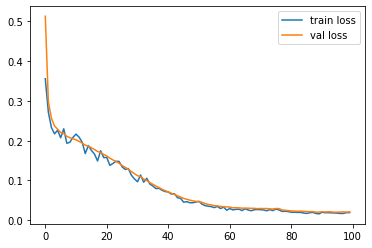

In [13]:
import matplotlib.pyplot as plt

plt.plot(val_epoch_loss_lst, label='train loss')

plt.plot(train_epoch_loss, label='val loss')
plt.legend()